**Problem Statement:-** Build model to classify sentiment classification using Xl-Net(LLMs).

**Architecture of Sentiment Classification using Xl-Net**:-  
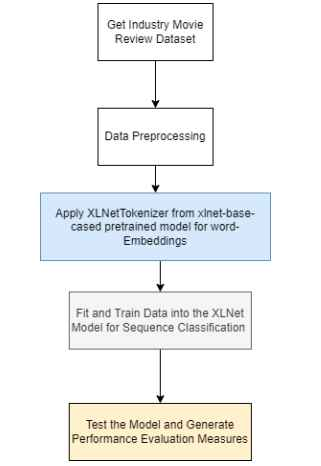

**Architecture of Xl-Net Model:-**



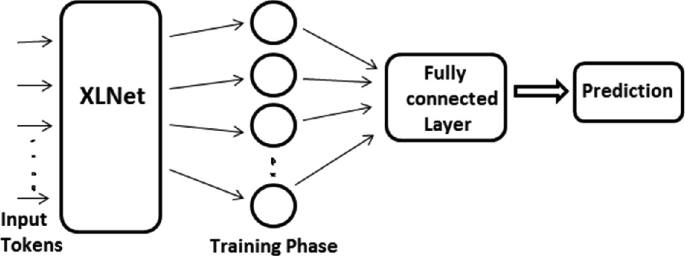

**Implementation Steps**:- We are implementing our model in 6 steps.
1.  Install and import all the dependencies required to set the code working.
2. Prepare data.
3. Writing function to perform train step and evaluation.
4. Fine-tuning XLNet model.
5. Evaluate performance of the model.
6. Making predictions on raw text.



Before implementing code we mount our google drive for importing the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu May 16 06:57:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Step 1**:- Install and import dependencies.

In [ ]:
!pip install transformers
#!pip install: A command used in Python to install packages from the Python Package Index (PyPI)

**Making the necessary imports**

In [ ]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
#The XLNet model is a variant of the Transformer architecture that utilizes an autoregressive method for pretraining.
#Tokenization: XLNetTokenizer is used to convert input text data into tokens that the XLNet model can process.
#AdamW is an optimizer that is based on the Adam optimizer and it is used to prevent overfitting.
#Learning Rate Scheduler: A technique used to adjust the learning rate during training to improve model performance.
import torch
#The torch library is commonly used for numeric computation.

import numpy as np
#Numpy is a fundamental package for scientific computing in python.
import pandas as pd
#Pandas is a fundamental library for data manipulation and analysis in python.It introduces two data structures: Series and data frame.
import seaborn as sns
#Seaborn is a python data visualization library.It simplifies the process of creating complex visualization by providing easy to use function.
import matplotlib.pyplot as plt
#Matplotlib is a widely used library for creating static, animated and interactive visualizations in python.It provides a high-level interface for creating a wide range of plots, charts, and graphs.
from matplotlib import rc
#Matplotlib's rc parameters can significantly enhance the visual appeal of your plots.
from sklearn.model_selection import train_test_split
#The train_test_split function in scikit-learn is a powerful tool for splitting datasets into training and testing sets.
from sklearn.metrics import accuracy_score
#The accuracy_score function from the sklearn.metrics module in Python calculates the accuracy of a classification model by comparing the true labels of the data with the predicted labels generated by the model.
from collections import defaultdict
#The defaultdict class from the collections module is a powerful tool that provides a default value for keys that have not been set yet.
from textwrap import wrap
#The textwrap.wrap function is used to wrap a single paragraph of text so that every line is at most a specified width.
from pylab import rcParams
#The pylab module is a part of the matplotlib library that combines the functionality of pyplot and numpy in a single namespace.

from torch import nn, optim
#The nn module in PyTorch provides support for building neural network architectures.
#The optim module is responsible for optimizing model parameters during the training process.
from keras.preprocessing.sequence import pad_sequences
#The pad_sequences function in Keras is used to pad sequences to a specified length.
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import classification_report

In [ ]:
%matplotlib inline
#The %matplotlib inline command is a magic command that sets the backend of Matplotlib to render plots inline.
%config InlineBackend.figure_format='retina'
#'retina' is used for high resolution of the plots

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
#Sets the styling parameters for seaborn plots

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
#The HAPPY_COLORS_PALETTE is a predefined list in Python that contains six different hex color codes representing bright and cheerful colors.

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42    #Random seed = ??
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**Step 2:**- Prepare and load data.
#Reading data using pandas

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/archive.zip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(10)

,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative
42724,I've watched this movie on a fairly regular ba...,positive
10822,For once a story of hope highlighted over the ...,positive
49498,"Okay, I didn't get the Purgatory thing the fir...",positive
4144,I was very disappointed with this series. It h...,negative
36958,The first 30 minutes of Tinseltown had my fing...,negative


**Shuffle** = shuffling the data is an important step to ensure that the model does not overfit to the training data. Overfitting occurs when the model learns the training data too well and performs poorly on unseen data.



**what type of technique used if data is not balanced ?**

 there are several techniques that can be used to address data imbalance in machine learning, including oversampling, undersampling, balanced sampling, cost-sensitive learning, and using specialized algorithms.

 **oversampling** = oversampling is a technique used to balance an imbalanced dataset by increasing the number of instances of the minority class.


In [ ]:
df = df[:20000]
len(df)

20000

 Function to clean text. Remove Tagged entities, emojis, hyperlink from the text.

In [ ]:
import re
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

In [ ]:
df['review'] = df['review'].apply(clean_text)

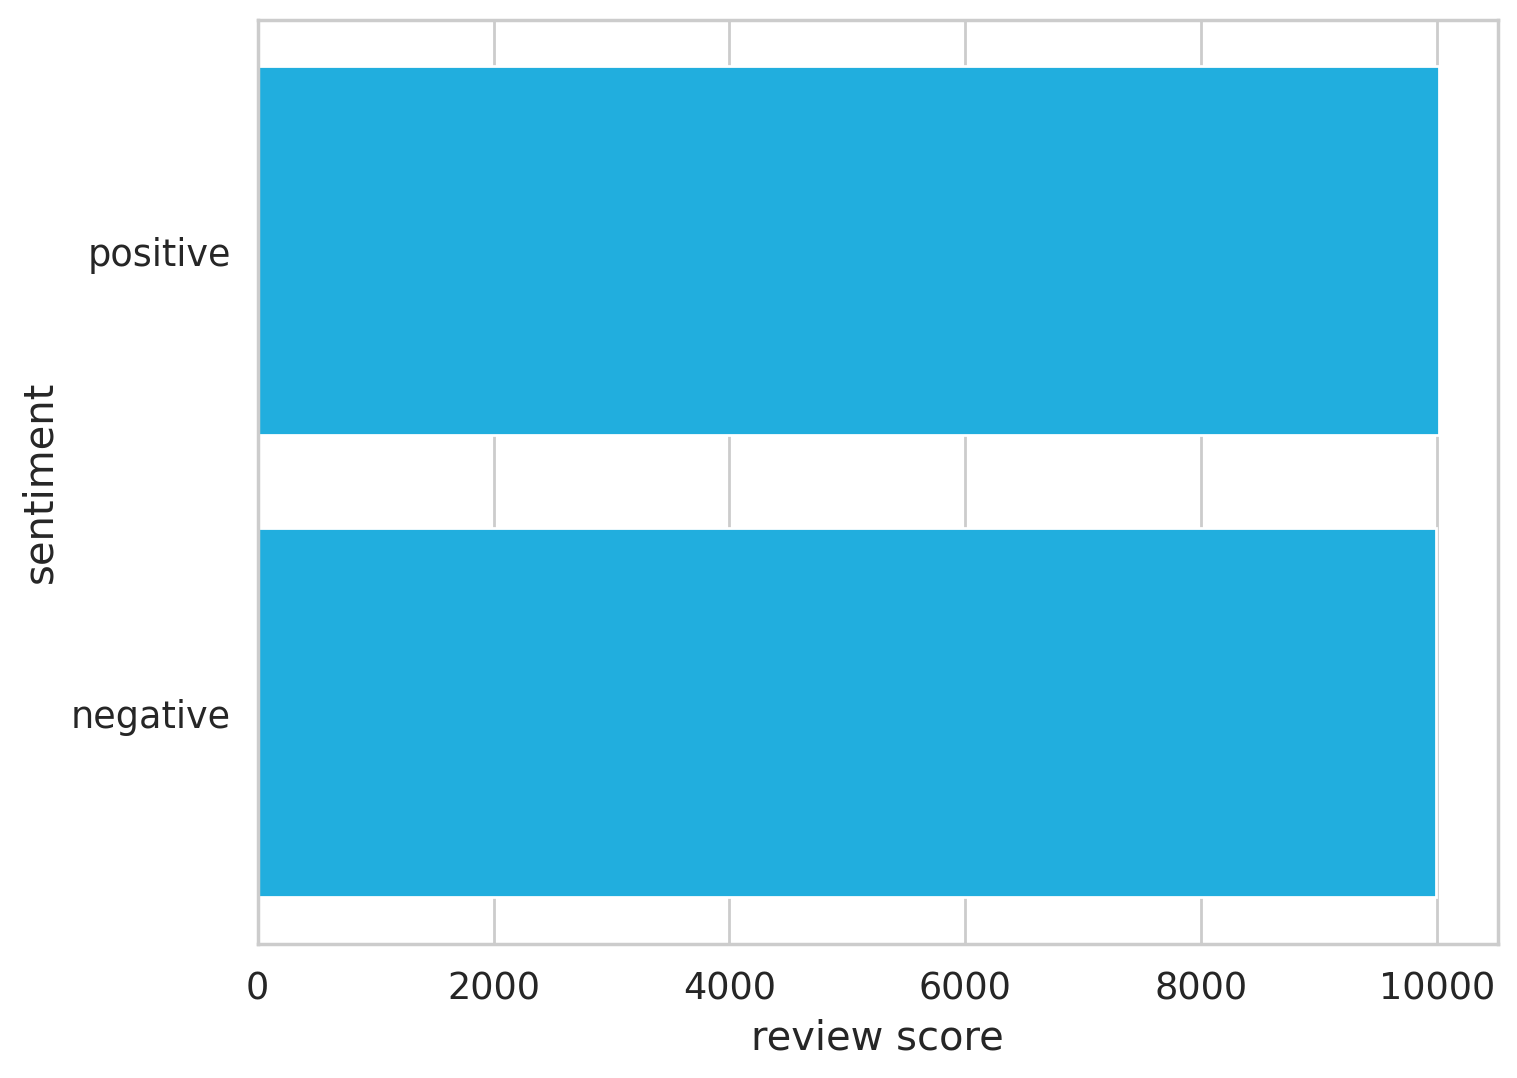

In [ ]:
rcParams['figure.figsize'] = 8, 6
#Using rcParams sets the size of the plot
sns.countplot(df.sentiment)
#The df.sentiment represents the column containing sentiment labels.
plt.xlabel('review score');

#Function to convert labels to numbers

In [ ]:
def sentiment2label(sentiment):
    if sentiment == "positive":
        return 1
    else :
        return 0

df['sentiment'] = df['sentiment'].apply(sentiment2label)

Why we convert labels to numbers ?

When we feed categorical data into a machine learning algorithm, it may not understand the categories and may treat them as separate entities. By converting categorical data into numerical values, we can ensure that the algorithm understands the relationship between the categories.

In [ ]:
df['sentiment'].value_counts()

sentiment
1    10011
0     9989
Name: count, dtype: int64

In [ ]:
#List of class names
class_names = ['negative', 'positive']

**XLnet Tokenizer**

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
input_txt = "India is my country. All Indians are my brothers and sisters"
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, truncation=True, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False)



The given code snippet is used to tokenize the input text and convert it into a format that can be used in a PyTorch tensor

In [ ]:
print('input_ids : ',encodings['input_ids'])

input_ids :  tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])


By printing the input IDs, we can see how the input text has been tokenized and encoded.

In [ ]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

['▁India',
 '▁is',
 '▁my',
 '▁country',
 '.',
 '▁All',
 '▁Indians',
 '▁are',
 '▁my',
 '▁brothers',
 '▁and',
 '▁sisters',
 '<sep>',
 '<cls>']

This code can be useful for debugging or checking the correctness of the encoding process, as we can see the original token corresponding to a specific input ID.

In [ ]:
type(encodings['attention_mask'])

torch.Tensor

In [ ]:
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")


In [ ]:
attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask)
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
encodings['input_ids']

tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])

What is attention mask =
A matrix used in neural networks to highlight or ignore specific tokens during computation, enhancing model focus and performance.

**Checking the distribution of token lengths**

In [ ]:
token_lens = []

for txt in df['review']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


**Why we checking the distribution of token lengths ?**

By checking the distribution of token lengths, you can ensure that most of your input text reviews are within the maximum input size of the model.

<ipython-input-25-1301f1bfee97>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


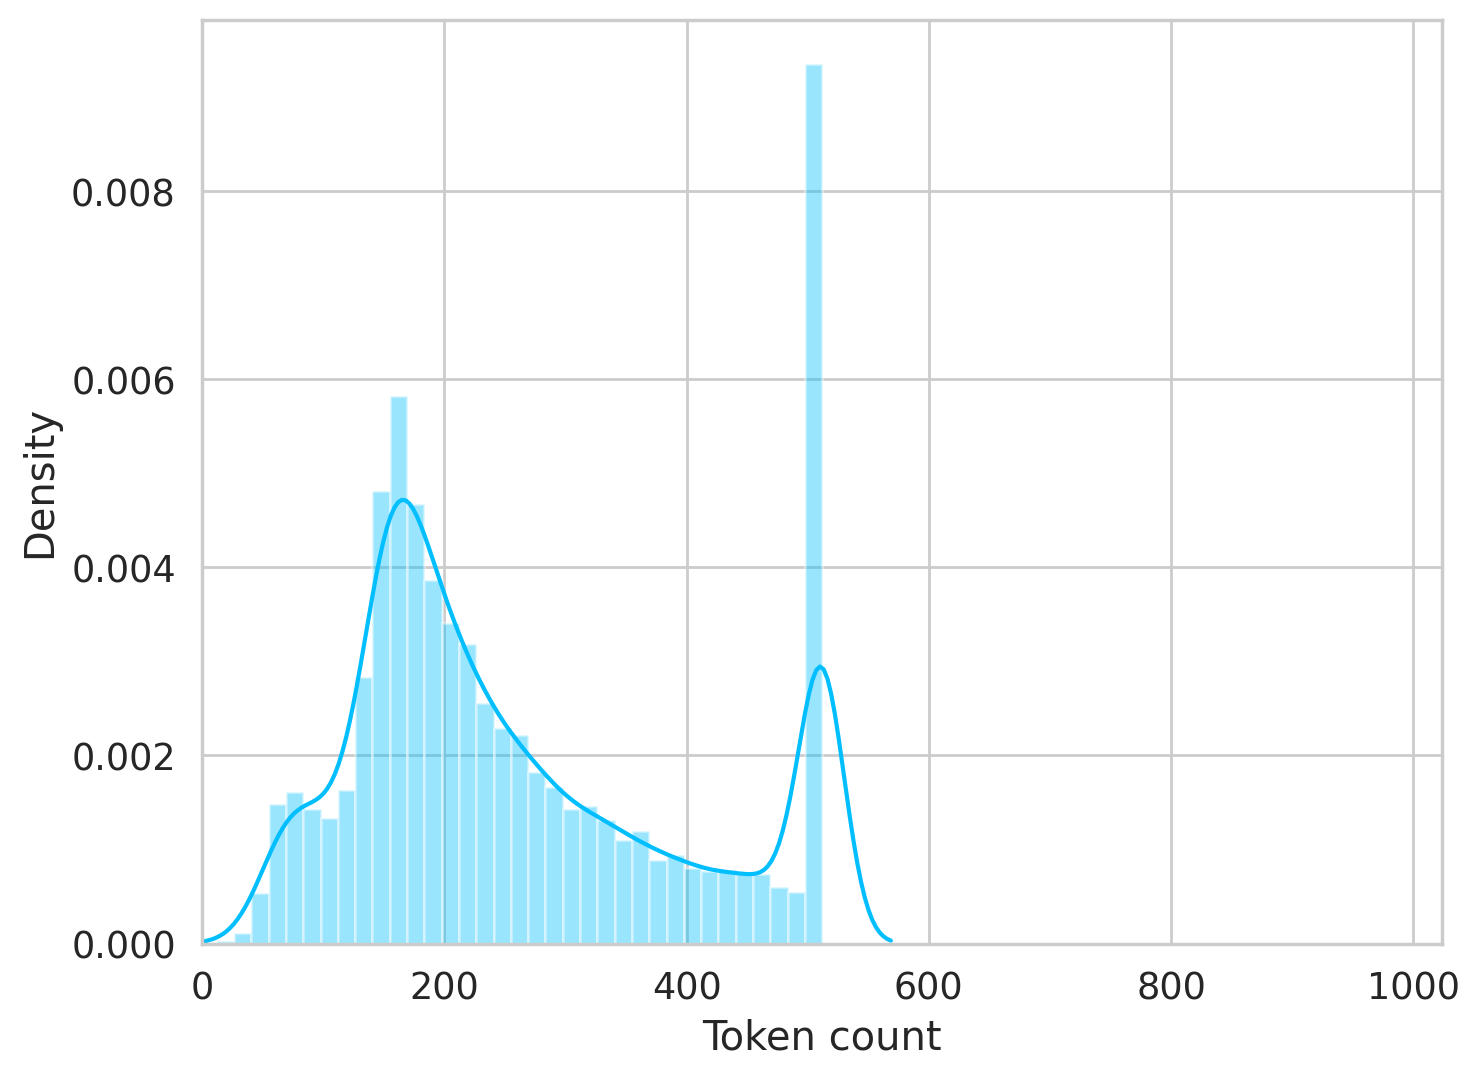

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

In this code snippet, we are utilizing Seaborn, a Python data visualization library, to create a distribution plot of token lengths. The purpose is to analyze the distribution of token counts in a given dataset.

In [ ]:
MAX_LEN = 512

**Custom Dataset Class**

In [ ]:
class ImdbDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids)

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In the above code snippet, we will delve into the ImdbDataset class, which is designed to tokenize reviews for sentiment analysis tasks using the IMDb dataset. The class takes reviews, targets, a tokenizer, and a maximum length parameter as input to prepare the data for model training

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.5, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

In this explanation, we will delve into how to split a dataset into training, validation, and test sets using Python. The code snippet provided showcases the process of dividing a DataFrame into training, validation, and test sets.

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((10000, 2), (5000, 2), (5000, 2))

**Custom Dataloader**

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ImdbDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Batch size = Batch size is the number of training examples used in one iteration of the training algorithm.

**Loading the pretrained XL-net Model**

In [ ]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

**Setting Up Hyperparameters**

In [ ]:
EPOCHS = 1

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

data = next(iter(val_data_loader))
data.keys()#This part accesses the keys of the data object

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(4,512).shape)
print(attention_mask.shape)

torch.Size([4, 512])
torch.Size([4, 512])


In [ ]:
input_ids[0]

tensor([[   35,    26,   215,   467,    37, 16125,    56,    29,    35,  3617,
            22,   343,  1991,   809,  3547,   370,    49,    86,    17,     9,
            35,    26,    98,    24,  2035,     9,   130,    52,    17,  7841,
         10397,    30, 10398,     9,    35,   685,    36,    28,   325,   351,
           706,    49,    17,   409,  1238,    21,   194,   567,    35,  1373,
           269,   178,     9,    84,    30,    24, 14220,  2842,    20,   580,
          1460,     9,    17,  2369,    17,  2369,    35,   675,    36,    24,
           156,   114,   149,   700,    49,   700,     9,   174,    30,    50,
           498,     9,  1134,    49,   611,  7207,   538,    74,   371,    36,
            24,  4427,    20,   161,   306,    21,   284,    17,  1238, 11157,
            23,    94,   823,     9, 13195,    63,    41,    71,   273,    20,
            18,  2195,    49,  2484,     9,    17,  2369,    17,  2369,    84,
           327,    39,    52,  1432,    30,   102,  

In [ ]:
outputs = model(input_ids.reshape(4,512), token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

XLNetForSequenceClassificationOutput(loss=tensor(0.7078, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[-0.1507,  0.0270],
        [-0.1994,  0.0256],
        [-0.2206,  0.0034],
        [-0.1921,  0.1369]], device='cuda:0', grad_fn=<AddmmBackward0>), mems=(tensor([[[ 2.5685e-02,  1.0615e-03, -4.4840e-02,  ..., -2.9657e-02,
           1.0618e-02, -8.7998e-03],
         [-1.3281e-02, -3.5867e-02, -3.3183e-02,  ..., -2.2503e-02,
           9.3750e-05,  1.8421e-02],
         [-3.4428e-02, -3.8492e-02, -4.2080e-02,  ...,  1.5152e-01,
          -1.3588e-01,  5.4392e-02],
         [ 2.5685e-02,  1.0615e-03, -4.4840e-02,  ..., -2.9657e-02,
           1.0618e-02, -8.7998e-03]],

        [[-5.6352e-02, -2.2485e-03, -2.9025e-02,  ...,  3.2931e-02,
           4.2999e-02, -1.9070e-02],
         [-3.6046e-02, -2.4926e-02, -1.2286e-02,  ...,  3.4411e-02,
           2.2929e-03, -2.7514e-02],
         [ 1.5331e-02, -1.3554e-02, -9.7810e-03,  ..., -1.9009e-03,
           4.9133e-02,  3.1

In [ ]:
type(outputs[0])

torch.Tensor

**Defining the training step function**

In [ ]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0

    for d in data_loader:
        input_ids = d["input_ids"].reshape(4,512).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

**Defining the evaluation function**

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

**Fine-tuning the pre-trained model**

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/NewModel/sentiment_model.h5')
        best_accuracy = val_acc

Epoch 1/1
----------
Train loss 0.36578128636364127 Train accuracy 0.9117


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Val loss 0.3266881583889946 Val accuracy 0.9306

CPU times: user 31min 28s, sys: 7min 22s, total: 38min 50s
Wall time: 40min 14s


**Evaluation of the Fine tuned model**

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NewModel/sentiment_model.h5'))


<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy : 0.9388
Test Loss : 0.28544542276018764


In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]

            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.93      0.95      0.94      2496
    positive       0.95      0.93      0.94      2504

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



**Custom prediction function on raw text**

In [ ]:
   def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids)

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask)

    input_ids = input_ids.reshape(1,512).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("Positive score:", probs[1])
    print("Negative score:", probs[0])
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
text = "Movie is the worst one I have ever seen!! The story has no meaning at all"
predict_sentiment(text)

Positive score: 0.0005420725792646408
Negative score: 0.9994578957557678
Review text: Movie is the worst one I have ever seen!! The story has no meaning at all
Sentiment  : negative


In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
torch.save(model.state_dict(), 'model.h5')